In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
# with help from http://planspace.org/20150423-forward_selection_with_statsmodels/
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response, ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < (best_new_score * 1):
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response, ' + '.join(selected))
    
    model = smf.ols(formula, data).fit()
    return (model, formula)

In [3]:
# make df to map from zipcode to state - in case we want to filter anything by state
# state_zip_map.to_pickle('data/state_zip_map.pkl')
state_zip_map = pd.read_pickle('data/state_zip_map.pkl')

### - house/rental ratio 2015 (below)

In [4]:
# read in the HOUSE/RENT ratio for 2015 - this is our response variable
ratio_response = pd.read_pickle('data/housing_rental_ratio.pkl').rename(columns = {'RegionName': 'zipcode'})
ratio_2015_response = ratio_response[['zipcode','ratio_2015']]

# create ratio_2011 feature to be predictor!
ratio_2011_feature = ratio_response[['zipcode','ratio_2011']]
# convert zipcode to string for merging
ratio_2011_feature['zipcode'] = ratio_2011_feature['zipcode'].astype('str')
ratio_2015_response['zipcode'] = ratio_2015_response['zipcode'].astype('str')

/Users/princess_eliza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/princess_eliza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
ratio_response.head(3)

,zipcode,r_agg_2011,r_agg_2015_adj,r_pct_delta,h_agg_2011,h_agg_2015_adj,h_pct_delta,ratio_2011,ratio_2015,ratio_pct_delta
0,11368,1.868000,2.188278,1.171455,373.833333,431.274105,1.153653,16.677076,16.423646,0.984804
1,79936,0.744167,0.694379,0.933096,80.333333,75.060164,0.934359,8.995894,9.008072,1.001354
2,60629,1.197000,1.180207,0.985971,107.166667,113.430961,1.058454,7.460782,8.009253,1.073514


In [6]:
ratio_2011_feature.head(3)

,zipcode,ratio_2011
0,11368,16.677076
1,79936,8.995894
2,60629,7.460782


In [7]:
ratio_2015_response.head(3)

,zipcode,ratio_2015
0,11368,16.423646
1,79936,9.008072
2,60629,8.009253


In [8]:
ratio_response.head(3)

,zipcode,r_agg_2011,r_agg_2015_adj,r_pct_delta,h_agg_2011,h_agg_2015_adj,h_pct_delta,ratio_2011,ratio_2015,ratio_pct_delta
0,11368,1.868000,2.188278,1.171455,373.833333,431.274105,1.153653,16.677076,16.423646,0.984804
1,79936,0.744167,0.694379,0.933096,80.333333,75.060164,0.934359,8.995894,9.008072,1.001354
2,60629,1.197000,1.180207,0.985971,107.166667,113.430961,1.058454,7.460782,8.009253,1.073514


In [9]:
type(ratio_2011_feature.zipcode[0])

str

In [10]:
# training and test sets were normalized and transformed, save indices for training and test sets
train_set_t = pd.read_pickle('data/train_all_features_norm_and_transform.pkl')
itrain_t_df = pd.DataFrame(train_set_t.index).rename(columns={0: 'ind'})

test_set_t = pd.read_pickle('data/test_all_features_norm_and_transform.pkl')
itest_t_df = pd.DataFrame(test_set_t.index).rename(columns={0: 'ind'})

features_t = pd.concat([train_set_t, test_set_t])

print features_t.shape
features_t = features_t.merge(ratio_2011_feature, how='inner', on='zipcode')
print features_t.shape

features_t.head(10)

(27653, 64)
(10306, 65)


,zipcode,prison,jail,A001,A002,A003,A004,A005,A006,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A044,A045,A046,A047,A048,A049,A050,A051,A052,A053,A054,A055,A056,n_establishments,paid_employees,first_quarter_payroll_1000,annual_payroll_1000,median_income,ratio_2011
0,10001,0,0,0.705328,-2.031023,-1.135912,2.294895,1.942141,-0.218610,-0.893023,-0.588661,-0.529584,-0.115231,-0.333473,-1.925327,-1.831279,1.068084,1.967260,0.747665,-0.459373,-0.662854,-0.602292,-0.253063,0.399350,-2.014213,-0.225760,3.505742,1.304157,-1.127013,-1.142562,-0.417745,-0.399504,0.236945,-0.851600,0.834700,-0.149252,2.861675,-0.133800,1.221584,-3.493941,-1.269827,-1.702523,-0.500855,-0.829323,3.353651,2.819859,0.180449,2.833866,0.389303,-2.233151,-0.950597,0.276436,0.000030,1.652446,-0.705530,-1.813748,-0.778935,1.167660,-1.364720,2.711458,2.445190,12.560277,15.095702,0.693742,22.633099
1,10004,0,0,-0.556611,-0.698808,-2.408038,2.827792,5.349627,0.168770,-1.852545,-1.616199,-1.805072,-1.404023,0.494576,-0.461050,-2.360739,2.029144,4.537319,0.406800,-1.445076,-1.275334,-1.438359,-2.090271,-0.428490,-0.940188,-2.014633,3.320389,4.951266,-0.206317,-1.963885,-1.770960,-1.999219,-2.467343,-0.599820,0.112318,-0.163576,3.152417,-0.133800,0.315554,-2.984955,-1.587049,-1.348257,-1.339249,-1.183090,2.636354,2.675904,-1.080578,1.771643,-1.929090,-1.794491,-2.757288,-0.499657,0.943057,0.430501,3.765116,-1.607731,-0.879722,0.106762,-1.306708,1.708991,2.009599,43.807521,22.836312,3.425215,20.913291
2,10005,0,0,-0.273160,-2.175829,-2.848389,6.175056,5.510358,-1.521614,-3.131906,-2.393118,-2.184271,-1.524848,-0.333473,-2.196489,-2.713713,3.748935,4.890072,-0.843038,-2.690175,-2.106558,-1.888549,-2.642891,0.399350,-1.957685,-2.519187,8.250774,4.759313,-1.740810,-3.058982,-2.422508,-2.265838,-2.687162,-0.604662,0.169533,-0.192224,3.122434,-0.133800,0.476450,-4.110083,-1.587049,-1.702523,-1.374182,-1.418935,2.940293,2.696469,-1.553463,2.282327,-2.090090,-2.629015,-3.157427,-0.295422,0.747632,0.957146,3.206285,-1.928201,-1.459244,0.646608,-1.480743,1.648564,1.878330,17.658659,12.195401,2.987331,19.775019
3,10006,0,0,-0.562076,-2.465441,-2.726069,6.008525,5.960403,-1.768128,-2.957448,-2.317933,-2.115325,-1.565122,0.124133,-2.413419,-2.537226,3.900682,5.343612,-0.956659,-2.482659,-1.931563,-1.824236,-2.354004,-0.058140,-2.296851,-2.473318,7.657645,5.015251,-2.047709,-2.894717,-2.422508,-2.199183,-2.927947,-0.643397,0.350326,-0.192224,3.053964,-0.133800,0.563504,-4.047576,-1.269827,-1.791089,-1.513914,-1.448415,2.891663,2.655339,-1.553463,2.200617,-2.122290,-2.746705,-3.169552,0.385362,-0.198718,0.712255,-0.146700,-1.905311,-1.585227,0.046635,-1.384057,1.400862,1.499415,3.560011,3.572028,2.700323,16.887626
4,10010,0,0,1.457182,-2.002062,-1.698583,3.060935,2.360040,-0.993369,-1.445475,-0.488414,-0.564057,-0.034682,-0.769288,-1.925327,-1.787157,1.573905,1.866473,-0.502173,-1.133801,-0.619105,-0.666604,-0.118329,0.835055,-1.844630,-1.280736,4.469576,2.391891,-1.249772,-1.525846,-0.317507,-0.399504,0.308114,-0.425510,0.534060,-0.177900,2.671048,-0.133800,0.689983,-3.440364,-1.745659,-1.791089,-1.007385,-1.212571,3.329336,1.894435,-0.029722,3.712243,0.485902,-2.308044,-0.950597,0.507903,-0.460237,0.529200,-0.466032,-1.905311,-1.056098,1.392632,-1.422731,2.170451,2.126492,17.839661,15.752131,1.904733,23.952420
5,10025,0,0,5.854390,-1.046342,-1.331624,1.279059,1.009904,-0.253826,-0.369648,0.012824,-0.012494,0.206967,-0.878241,-1.003375,-1.345941,0.612845,0.606640,-0.331740,-0.459373,-0.312865,-0.280727,0.010670,0.943981,-0.940188,-1.097262,1.948778,1.240172,-0.083557,-0.156975,0.384160,0.133734,0.697549,-0.856442,1.179257,-0.149252,1.992985,-0.003945,1.448617,-2.252729,-1.005476,-1.348257,0.058074,-0.475556,2.271627,1.215790,0.443162,2.609165,0.743502,-1.355830,-0.186695,0.610021,-0.720718,0.529200,-0.625698,-1.218588,-0.375790,1.985982,-0.919964

In [11]:
# full df with features and resp. vars for HOUSE/RENT ratio 2015 response
merged_ratio_2015 = ratio_2015_response.merge(features_t, how='inner', on=['zipcode'])
merged_ratio_2015 = merged_ratio_2015.astype('float')
merged_ratio_2015 = merged_ratio_2015.rename(columns={'ratio_2015':'response'})

features_t.shape, merged_ratio_2015.shape

((10306, 65), (10306, 66))

In [12]:
# split into training and test sets, house/rental ratio 2015 response
ratio_2015_train = merged_ratio_2015.merge(itrain_t_df, how='inner', right_on='ind', left_index=True)
ratio_2015_test = merged_ratio_2015.merge(itest_t_df, how='inner', right_on='ind', left_index=True)

In [13]:
print '%s samples in training set \n%s samples in test set'%(ratio_2015_train.shape[0], ratio_2015_test.shape[0])

8201 samples in training set 
2105 samples in test set


# baseline - average of 2015 house/rent ratio values
by Austin

In [14]:
# function to get rmse
def get_rmse(s, s_predict):
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

train_ratio_2015_observed = ratio_2015_train['ratio_2011'].dropna().tolist()
test_ratio_2015_observed = ratio_2015_test['response'].dropna().tolist()
train_ratio_2015_mean = np.mean(ratio_2015_train['ratio_2011'].dropna().tolist())

baseline_rmse = get_rmse(np.array(test_ratio_2015_observed), np.array([train_ratio_2015_mean]*len(test_ratio_2015_observed)))

print 'Response Variable: Ratio 2015'
print 'RMSE for baseline - average is ' + str(baseline_rmse)

Response Variable: Ratio 2015
RMSE for baseline - average is 3.52634585429


## baseline - 2011 ratio

In [15]:
len(ratio_2015_test['response'].dropna().tolist()), len(ratio_2015_test.ratio_2011.dropna().tolist())

(2105, 1971)

In [16]:
temp = ratio_2015_test[['response','ratio_2011']].dropna()
test_ratio_2015_obs = temp.response.tolist()
ratio_2011_obs = temp.ratio_2011.tolist()

baseline_ratio_rmse = get_rmse(np.array(test_ratio_2015_obs), np.array(ratio_2011_obs))

print 'Response Variable: Ratio 2015'
print 'RMSE for baseline - 2011 ratio is ' + str(baseline_ratio_rmse)

Response Variable: Ratio 2015
RMSE for baseline - 2011 ratio is 1.52600977525


In [18]:
import time
start_time = time.time()

# house/rental ratio 2015 response
bestmodel_ratio_2015 = forward_selected(ratio_2015_train.drop(['zipcode','ind'],1), 'response')

print '%s seconds to train model'%(time.time() - start_time)

68.7198932171 seconds to train model


In [19]:
import patsy
from statsmodels.api import add_constant

formula = bestmodel_ratio_2015[1].replace('response ~ ','')
data = ratio_2015_test.drop(['zipcode','ind'],1).dropna()
response = data['response']
data = data.drop('response',1)

df = patsy.dmatrix(formula, data=data)
pred = bestmodel_ratio_2015[0].predict(df, transform=False)

ols_rmse = get_rmse(response, pred)

print 'Response Variable: Ratio 2015'
print 'RMSE for OLS is ' + str(ols_rmse)

Response Variable: Ratio 2015
RMSE for OLS is 1.14147816188


In [20]:
bestmodel_ratio_2015[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     1909.
Date:                Thu, 10 Dec 2015   Prob (F-statistic):               0.00
Time:                        18:34:50   Log-Likelihood:                -11857.
No. Observations:                7685   AIC:                         2.380e+04
Df Residuals:                    7644   BIC:                         2.408e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                      1.7364      0.062     27.981      0.000         1.615     1.858
ratio_2011                     0.8592      0.006    151.170      0.000         0.848     0.870
A036                           0.1550      0.023      6.861      0.000         0.111     0.199
A034                           0.1890      0.022      8.515      0.000         0.145     0.233
A032                          -0.5289      0.028    -18.726      0.000        -0.584    -0.474
A056                           0.6326      0.040     15.627      0.000         0.553     0.712
A002                          -0.3645      0.047     -7.809      0.000        -0.456    -0.273
A031                          -0.5173      0.036    -14.208      0.000        -0.589    -0.446
A052                           0.1313      0.019      6.863      0.000         0.094     0.169
median_income                  0.2550      0.025     10.121      0.000         0.206     0.304
A037                          -1.2984      0.099    -13.075      0.000        -1.493    -1.104
A039                           0.5121      0.055      9.392      0.000         0.405     0.619
A014                          -0.2174      0.117     -1.861      0.063        -0.446     0.012
A042                          -3.2319      2.130     -1.517      0.129        -7.408     0.944
A040                          -0.1489      0.085     -1.748      0.081        -0.316     0.018
A001                           0.1083      0.020      5.421      0.000         0.069     0.147
A049                           0.1529      0.055      2.773      0.006         0.045     0.261
A051                           0.1667      0.026      6.406      0.000         0.116     0.218
A004                          -0.0766      0.109     -0.700      0.484        -0.291     0.138
A038                          -0.2871      0.061     -4.710      0.000        -0.407    -0.168
first_quarter_payroll_1000     0.0540      0.013      4.217      0.000         0.029     0.079
paid_employees                -0.2071      0.070     -2.958      0.003        -0.344    -0.070
A030                          -0.0677      0.054     -1.264      0.206        -0.173     0.037
A005                           0.2290      0.078      2.950      0.003         0.077     0.381
A018                           0.3436      0.069      4.984      0.000         0.208     0.479
A054                           0.3726      0.134      2.789      0.005         0.111     0.634
A016                           0.1030      0.044      2.347      0.019         0.017     0.189
A020                           0.1118      0.055      2.050      0.040         0.005     0.219
A019                          -0.1145      0.073     -1.574      0.115        -0.257     0.028
A048                           0.2044      

## get features from forward selection to use in sklearn regressions

In [21]:
# house/rental ratio 2015 response
best_features_ratio_2015 = bestmodel_ratio_2015[0].params.index.values.tolist() + ['response', 'zipcode']

In [22]:
best_features_ratio_2015, len(best_features_ratio_2015)

(['Intercept',
  'ratio_2011',
  'A036',
  'A034',
  'A032',
  'A056',
  'A002',
  'A031',
  'A052',
  'median_income',
  'A037',
  'A039',
  'A014',
  'A042',
  'A040',
  'A001',
  'A049',
  'A051',
  'A004',
  'A038',
  'first_quarter_payroll_1000',
  'paid_employees',
  'A030',
  'A005',
  'A018',
  'A054',
  'A016',
  'A020',
  'A019',
  'A048',
  'A015',
  'A053',
  'A047',
  'n_establishments',
  'jail',
  'A050',
  'A010',
  'A029',
  'A041',
  'A045',
  'A043',
  'response',
  'zipcode'],
 43)

In [23]:
# house/rental ratio response
bad_features_ratio_2015 = [el for el in ratio_2015_train.columns if (el not in best_features_ratio_2015)]

ratio_2015_train_best = ratio_2015_train.drop(bad_features_ratio_2015 + ['ind'], 1).dropna()
ratio_2015_test_best = ratio_2015_test.drop(bad_features_ratio_2015 + ['ind'], 1).dropna()

In [24]:
ratio_2015_train_best.shape, ratio_2015_test_best.shape

((7685, 42), (1971, 42))

In [25]:
ratio_2015_test_best.head(2)

,zipcode,response,jail,A001,A002,A004,A005,A010,A014,A015,A016,A018,A019,A020,A029,A030,A031,A032,A034,A036,A037,A038,A039,A040,A041,A042,A043,A045,A047,A048,A049,A050,A051,A052,A053,A054,A056,n_establishments,paid_employees,first_quarter_payroll_1000,median_income,ratio_2011
0,11385,19.298078,0,6.134058,0.141067,0.79612,1.524241,-0.558254,0.562263,1.211360,0.065935,-0.881597,-0.795230,-0.697421,-0.532813,-0.418666,-0.827391,0.169533,1.724083,2.078333,0.202907,1.215074,0.245938,1.123533,0.880550,-0.378725,-0.429409,-0.189385,0.623491,-0.611085,0.623636,-0.759234,0.529200,-0.705530,0.727125,0.808451,0.743034,1.843039,1.372071,0.516955,-0.083944,20.506601
1,60647,13.363215,0,5.342342,0.314834,1.99514,3.324423,-1.081825,1.447450,2.874339,-0.331740,-1.319083,-1.309733,-1.413919,-1.332671,-1.443004,-1.084013,0.693437,0.720948,2.285006,-1.520503,0.369150,-0.019761,0.599537,0.615225,0.654669,0.845620,0.260017,-0.253830,-1.872131,0.337707,-0.108428,1.305335,-0.066867,0.017512,0.934434,0.085570,1.775407,1.436068,0.426005,-0.107480,13.133043


## Linear Regression with Lasso Regularization (normalized and transformed features)

In [26]:
from sklearn.linear_model import LassoCV
# HOUSE/RENTAL RATIO 2015 RESPONSE
start_time = time.time()

X_train = ratio_2015_train_best.drop(['response','zipcode'], 1)
Y_train = ratio_2015_train_best['response']
X_test = ratio_2015_test_best.drop(['response','zipcode'], 1)
Y_test = ratio_2015_test_best['response']

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
alphas_temp = [0.001, 0.01]
lasso_model_ratio_2015 = LassoCV(alphas = alphas, verbose=0).fit(X_train, Y_train)
best_alpha_lasso = lasso_model_ratio_2015.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_lasso)

# calculate accuracy
start_time = time.time()

training_accuracy = lasso_model_ratio_2015.score(X_train, Y_train)
test_accuracy = lasso_model_ratio_2015.score(X_test, Y_test)
print '#### based on the best Linear Regression with Lasso Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)
print '----- %s seconds to run -----'%(time.time() - start_time)

lasso_pred_ratio_2015 = lasso_model_ratio_2015.predict(X_test)
lasso_rmse = get_rmse(lasso_pred_ratio_2015, Y_test)

print 'Response Variable: House/Rental 2015 Ratio'
print 'RMSE for Lasso: ' + str(lasso_rmse)

----- 0.0707099437714 seconds to run ----- 
---- best alpha = 0.01 ----
#### based on the best Linear Regression with Lasso Regularization ####
R-squared on training data: 0.91
R-squared on test data:     0.90
----- 0.00216698646545 seconds to run -----
Response Variable: House/Rental 2015 Ratio
RMSE for Lasso: 1.15735294342


/Users/princess_eliza/anaconda/lib/python2.7/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


## linear regression where only feature is 2011 ratio

In [28]:
# HOUSE/RENTAL RATIO 2015 RESPONSE
start_time = time.time()

X_train_small = ratio_2015_train_best['ratio_2011'].values
# add intercept to feature matrix - sklearn didn't like having only 1 feature
X_train_small = np.vstack((X_train_small, np.array([1]*X_train_small.shape[0]))).T
Y_train_small = ratio_2015_train_best['response'].values
X_test_small = ratio_2015_test_best['ratio_2011'].values
X_test_small = np.vstack((X_test_small, np.array([1]*X_test_small.shape[0]))).T
Y_test_small = ratio_2015_test_best['response'].values

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
lasso_model_ratio_2015_small = LassoCV(alphas = alphas, fit_intercept=False, verbose=0).fit(X_train_small, Y_train_small)
best_alpha_lasso_small = lasso_model_ratio_2015_small.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_lasso_small)

# calculate accuracy
start_time = time.time()

training_accuracy = lasso_model_ratio_2015_small.score(X_train_small, Y_train_small)
test_accuracy = lasso_model_ratio_2015_small.score(X_test_small, Y_test_small)
print '#### based on the best Linear Regression with Lasso Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)
print '----- %s seconds to run -----'%(time.time() - start_time)

lasso_pred_ratio_2015_small = lasso_model_ratio_2015_small.predict(X_test_small)
lasso_rmse = get_rmse(lasso_pred_ratio_2015_small, Y_test)

print 'Response Variable: House/Rental 2015 Ratio'
print 'RMSE for Lasso: ' + str(lasso_rmse)

----- 0.0303649902344 seconds to run ----- 
---- best alpha = 0.01 ----
#### based on the best Linear Regression with Lasso Regularization ####
R-squared on training data: 0.86
R-squared on test data:     0.84
----- 0.00235104560852 seconds to run -----
Response Variable: House/Rental 2015 Ratio
RMSE for Lasso: 1.41956344867


## Linear Regression with Ridge Regularization (normalized and transformed features)

In [29]:
from sklearn.linear_model import RidgeCV
# HOUSE/RENTAL RATIO 2015 RESPONSE
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model_ratio_2015 = RidgeCV(alphas = alphas).fit(X_train, Y_train)
best_alpha_ridge = ridge_model_ratio_2015.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_ridge)

training_accuracy = ridge_model_ratio_2015.score(X_train, Y_train)
test_accuracy = ridge_model_ratio_2015.score(X_test, Y_test)
print '#### based on the best Linear Regression with Ridge Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)

ridge_pred_ratio_2015 = ridge_model_ratio_2015.predict(X_test)
ridge_rmse = get_rmse(ridge_pred_ratio_2015, Y_test)

print 'Response Variable: Housing/Rental Ratio 2015'
print 'RMSE for Ridge: ' + str(ridge_rmse)

----- 0.0417251586914 seconds to run ----- 
---- best alpha = 10.0 ----
#### based on the best Linear Regression with Ridge Regularization ####
R-squared on training data: 0.91
R-squared on test data:     0.90
Response Variable: Housing/Rental Ratio 2015
RMSE for Ridge: 1.14202754673


In [30]:
# HOUSE/RENTAL RATIO 2015 RESPONSE
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model_ratio_2015_small = RidgeCV(alphas = alphas).fit(X_train_small, Y_train_small)
best_alpha_ridge_small = ridge_model_ratio_2015_small.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_ridge_small)

training_accuracy = ridge_model_ratio_2015_small.score(X_train_small, Y_train_small)
test_accuracy = ridge_model_ratio_2015_small.score(X_test_small, Y_test_small)
print '#### based on the best Linear Regression with Ridge Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)

ridge_pred_ratio_2015_small = ridge_model_ratio_2015_small.predict(X_test_small)
ridge_rmse = get_rmse(ridge_pred_ratio_2015_small, Y_test_small)

print 'Response Variable: Housing/Rental Ratio 2015'
print 'RMSE for Ridge: ' + str(ridge_rmse)

----- 0.00384902954102 seconds to run ----- 
---- best alpha = 10.0 ----
#### based on the best Linear Regression with Ridge Regularization ####
R-squared on training data: 0.86
R-squared on test data:     0.84
Response Variable: Housing/Rental Ratio 2015
RMSE for Ridge: 1.41946739093


## K-Fold Cross Validation to See if Demographic + Business Features Improve Model

In [31]:
from sklearn.linear_model import Ridge
# split training data into 5 sets and train on 4/5 at a time, validate on the last 1/5
train_inds = ratio_2015_train_best.zipcode.values.astype('int').astype('str')
size = 1573
train_sets = [train_inds[0*size:1*size],train_inds[1*size:2*size],train_inds[2*size:3*size],train_inds[3*size:4*size],train_inds[4*size:]]

ratio_2015_train_best['zipcode'] = ratio_2015_train_best.astype('int').astype('str')
# we found that the best alpha = 0.1 from cross validation above
a = 0.1
train_scores_full = []
train_scores_single = []
rmse_full = []
test_scores_full = []
test_scores_single = []
rmse_single = []

for i in xrange(len(train_sets)):
    # split into training (t) and validation (v) set
    t = [(z in train_sets[i]) for z in ratio_2015_train_best.zipcode]
    v = [(z not in train_sets[i]) for z in ratio_2015_train_best.zipcode]
    tempt = ratio_2015_train_best[t]
    tempv = ratio_2015_train_best[v]
    
    x_train = tempt.drop(['response','zipcode'], 1).values
    y_train = tempt['response'].values
    x_test = tempv.drop(['response','zipcode'], 1).values
    y_test = tempv['response'].values
    
    x_train_small = tempt['ratio_2011'].values
    x_train_small = np.vstack((x_train_small, np.array([1]*x_train_small.shape[0]))).T
    x_test_small = tempv['ratio_2011'].values
    x_test_small = np.vstack((x_test_small, np.array([1]*x_test_small.shape[0]))).T
    
    model = Ridge(alpha = a).fit(x_train, y_train)
    train_scores_full.append(model.score(x_train, y_train))
    test_scores_full.append(model.score(x_test, y_test))
    pred = model.predict(x_test)
    rmse_full.append(get_rmse(pred, y_test))
    
    model_small = Ridge(alpha = a, fit_intercept=False).fit(x_train_small, y_train)
    train_scores_single.append(model_small.score(x_train_small, y_train))
    test_scores_single.append(model_small.score(x_test_small, y_test))
    pred = model_small.predict(x_test_small)
    rmse_single.append(get_rmse(pred, y_test))
    
print '---- Mean training r-squared for 2011_ratio feature only = %s ----'%(np.mean(train_scores_single))
print '---- Mean training r-squared for all features = %s ----'%(np.mean(train_scores_full))
print '---- Mean test r-squared for 2011_ratio feature only = %s ----'%(np.mean(test_scores_single))
print '---- Mean test r-squared for all features = %s ----'%(np.mean(test_scores_full))
print '---- Mean rmse for 2011_ratio feature only = %s ----'%(np.mean(rmse_single))
print '---- Mean rmse for all features = %s ----'%(np.mean(rmse_full))

---- Mean training r-squared for 2011_ratio feature only = 0.859451258278 ----
---- Mean training r-squared for all features = 0.911650468007 ----
---- Mean test r-squared for 2011_ratio feature only = 0.843462265221 ----
---- Mean test r-squared for all features = 0.8821511983 ----
---- Mean rmse for 2011_ratio feature only = 1.47931958303 ----
---- Mean rmse for all features = 1.27877481008 ----


## Conclusions from k-folds cross validation

The mean r-squared value for the model that included all features (demographic, business, jail, prison, 2011_ratio) was higher than the mean r-squared value for themodel that was trained on only the 2011_ratio feature.  The rmse was also lower for the model with all features.  Both of these are indications that the extra business and demographic features do indeed add predictive value.

In [32]:
np.mean(rmse_full), np.mean(rmse_single)

(1.2787748100836507, 1.4793195830271564)

In [33]:
np.mean(train_scores_full), np.mean(test_scores_full), np.mean(train_scores_single), np.mean(test_scores_single)

(0.91165046800710281,
 0.88215119830048661,
 0.85945125827773372,
 0.84346226522098688)

In [34]:
from sklearn.linear_model import RidgeCV
# HOUSE/RENTAL RATIO 2015 RESPONSE
start_time = time.time()

alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
ridge_model_ratio_2015 = RidgeCV(alphas = alphas).fit(X_train, Y_train)
best_alpha_ridge = ridge_model_ratio_2015.alpha_

print '----- %s seconds to run ----- \n---- best alpha = %s ----'%(time.time() - start_time, best_alpha_ridge)

training_accuracy = ridge_model_ratio_2015.score(X_train, Y_train)
test_accuracy = ridge_model_ratio_2015.score(X_test, Y_test)
print '#### based on the best Linear Regression with Ridge Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)

ridge_pred_ratio_2015 = ridge_model_ratio_2015.predict(X_test)
ridge_rmse = get_rmse(ridge_pred_ratio_2015, Y_test)

print 'Response Variable: Housing/Rental Ratio 2015'
print 'RMSE for Ridge: ' + str(ridge_rmse)

----- 0.0553960800171 seconds to run ----- 
---- best alpha = 10.0 ----
#### based on the best Linear Regression with Ridge Regularization ####
R-squared on training data: 0.91
R-squared on test data:     0.90
Response Variable: Housing/Rental Ratio 2015
RMSE for Ridge: 1.14202754673


In [35]:
# get nice colors for plotting
sns_colors = sns.color_palette("hls", 8)

/Users/princess_eliza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


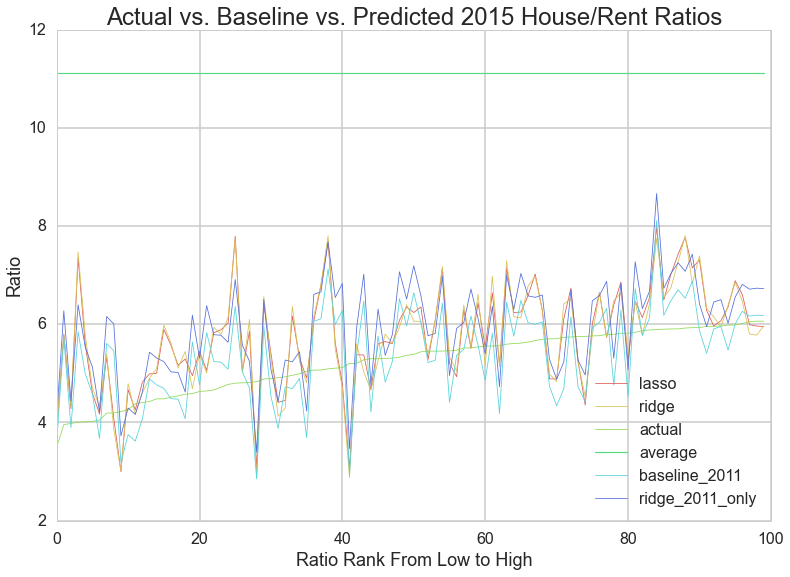

In [36]:
# plot to show difference between baseline, lasso, and ridge regressions
# HOUSE/RENTAL ratio 2015

ratio_2015_preds_df = pd.DataFrame({'baseline_2011':ratio_2015_test_best.ratio_2011, 'baseline':train_ratio_2015_mean,'lasso':lasso_pred_ratio_2015, 'ridge': ridge_pred_ratio_2015,'actual':ratio_2015_test_best.response,'ridge_2011_only':ridge_pred_ratio_2015_small})
ratio_2015_preds_df = ratio_2015_preds_df.sort('actual')

m=0
n=100
lw = 0.8

plt.plot(ratio_2015_preds_df.lasso[m:n], color=sns_colors[0], linewidth=lw, label='lasso')
plt.plot(ratio_2015_preds_df.ridge[m:n], color=sns_colors[1], linewidth=lw, label='ridge')
plt.plot(ratio_2015_preds_df.actual[m:n], color=sns_colors[2], linewidth=lw, label='actual')
plt.plot(ratio_2015_preds_df.baseline[m:n], color=sns_colors[3], linewidth=1.2, label='average')
plt.plot(ratio_2015_preds_df.baseline_2011[m:n], color=sns_colors[4], linewidth=lw, label='baseline_2011')
plt.plot(ratio_2015_preds_df.ridge_2011_only[m:n], color=sns_colors[5], linewidth=lw, label='ridge_2011_only')
plt.legend(loc='best')
plt.title('Actual vs. Baseline vs. Predicted 2015 House/Rent Ratios', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.show()

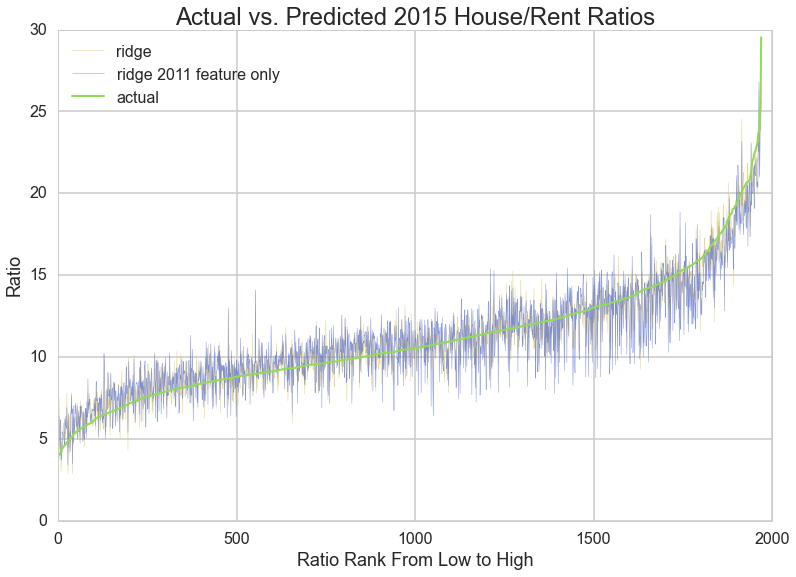

In [37]:
# plot to show difference between baseline, lasso, and ridge regressions
# HOUSE/RENTAL ratio 2015

m=0
n=1970
lw = 1

plt.plot(ratio_2015_preds_df.ridge[m:n], color=sns_colors[1], alpha=.7, linewidth=.5, label='ridge')
plt.plot(ratio_2015_preds_df.ridge_2011_only[m:n], color=sns_colors[5], alpha=.7, linewidth=.5, label='ridge 2011 feature only')
plt.plot(ratio_2015_preds_df.actual[m:n], color=sns_colors[2], linewidth=2, label='actual')
plt.legend(loc='best')
plt.title('Actual vs. Predicted 2015 House/Rent Ratios', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.show()

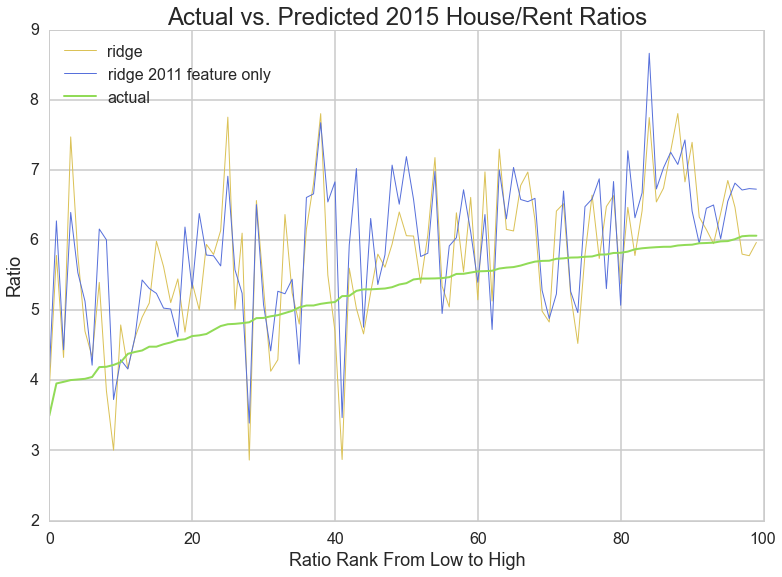

In [38]:
# plot to show difference between baseline, lasso, and ridge regressions
# HOUSE/RENTAL ratio 2015

m=0
n=100
lw = 1

plt.plot(ratio_2015_preds_df.ridge[m:n], color=sns_colors[1], linewidth=1, label='ridge')
plt.plot(ratio_2015_preds_df.ridge_2011_only[m:n], color=sns_colors[5], linewidth=1, label='ridge 2011 feature only')
plt.plot(ratio_2015_preds_df.actual[m:n], color=sns_colors[2], linewidth=2, label='actual')
plt.legend(loc='best')
plt.title('Actual vs. Predicted 2015 House/Rent Ratios', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Ratio', fontsize=18)
plt.show()

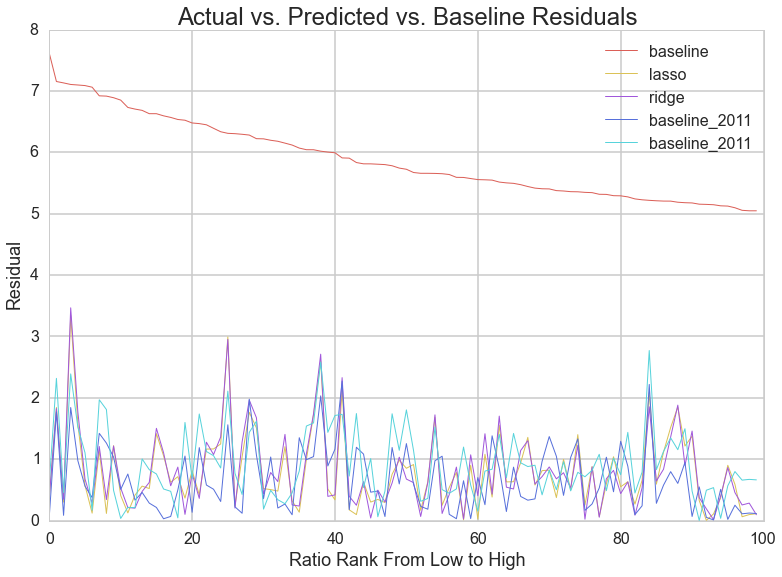

In [39]:
lw=1
# plt.plot(ratio_2015_preds_df.actual[m:n], color='b', linewidth=0.5, label='actual')
plt.plot(abs(ratio_2015_preds_df.baseline[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[0], linewidth=lw, label='baseline')
plt.plot(abs(ratio_2015_preds_df.lasso[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[1], linewidth=lw, label='lasso')
plt.plot(abs(ratio_2015_preds_df.ridge[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[6], linewidth=lw, label='ridge')
plt.plot(abs(ratio_2015_preds_df.baseline_2011[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[5], linewidth=lw, label='baseline_2011')
plt.plot(abs(ratio_2015_preds_df.ridge_2011_only[m:n] - ratio_2015_preds_df.actual[m:n]), color=sns_colors[4], linewidth=lw, label='baseline_2011')


plt.legend(loc='best')
plt.title('Actual vs. Predicted vs. Baseline Residuals', fontsize=24)
plt.xlabel('Ratio Rank From Low to High', fontsize=18)
plt.ylabel('Residual', fontsize=18)
plt.show()

#svm's

## Filter By State Plots

In [40]:
zip_resp_test_map = ratio_2015_test_best[['zipcode','response']]
zip_resp_test_map['zipcode'] = zip_resp_test_map['zipcode'].astype('int').astype('str')
state_resp_map = state_zip_map.merge(zip_resp_test_map, how='inner', on='zipcode')
state_resp_map = state_resp_map.rename(columns={'response':'actual'})

/Users/princess_eliza/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [41]:
state_resp_map.head(2)

,state,zipcode,actual
0,NY,10005,23.419206
1,NY,10006,20.339672


In [42]:
# don't run this multiple times - if you do, go up a couple cells and re-creat original 'ratio_2015_preds_df'
ratio_2015_preds_df = ratio_2015_preds_df.merge(state_resp_map, how='inner', on='actual')

In [43]:
# code to create residuals

# zip_resp_train_map = ratio_2015_train_best[['zipcode','response']]
# zip_resp_train_map['zipcode'] = zip_resp_train_map['zipcode'].astype('int').astype('str')
# state_resp_map = state_zip_map.merge(zip_resp_train_map, how='inner', on='zipcode')
# state_resp_map = state_resp_map.rename(columns={'response':'actual'})

# # ratio_2015_preds_df
# ridge_pred_train = ridge_model_ratio_2015.predict(X_train)
# temp = pd.DataFrame({'actual':Y_train, 'ridge':ridge_pred_train})
# print temp.shape
# ratio_2015_preds_df2 = temp.merge(state_resp_map, how='inner', on='actual')

# temp = pd.concat([ratio_2015_preds_df[['actual','ridge','zipcode','state']], ratio_2015_preds_df2])
# temp['residuals'] = temp.actual - temp.ridge
# temp.to_pickle('data/best_model_residuals.pkl')

In [44]:
ratio_2015_preds_df['state'] = [el.upper() for el in ratio_2015_preds_df['state']]
states = ratio_2015_preds_df['state'].drop_duplicates().values.tolist()
len(states)

42

In [45]:
ratio_2015_preds_df.head(3)

,actual,baseline,baseline_2011,lasso,ridge,ridge_2011_only,state,zipcode
0,3.494189,11.108624,3.560237,3.862726,3.874592,4.103016,IL,62206
1,3.954848,11.108624,5.724862,5.799504,5.780083,6.272318,MO,64130
2,3.977834,11.108624,3.892028,4.278288,4.325891,4.435524,MI,48234


In [46]:
np.array(states)

array(['IL', 'MO', 'MI', 'GA', 'PA', 'OH', 'NY', 'TN', 'AL', 'MS', 'TX',
       'FL', 'OK', 'IN', 'AZ', 'SC', 'KY', 'KS', 'IA', 'NC', 'CA', 'LA',
       'AR', 'NE', 'WV', 'CO', 'MD', 'VA', 'MN', 'DE', 'NV', 'WI', 'WA',
       'NM', 'ID', 'DC', 'AK', 'OR', 'UT', 'MT', 'ND', 'HI'], 
      dtype='|S2')

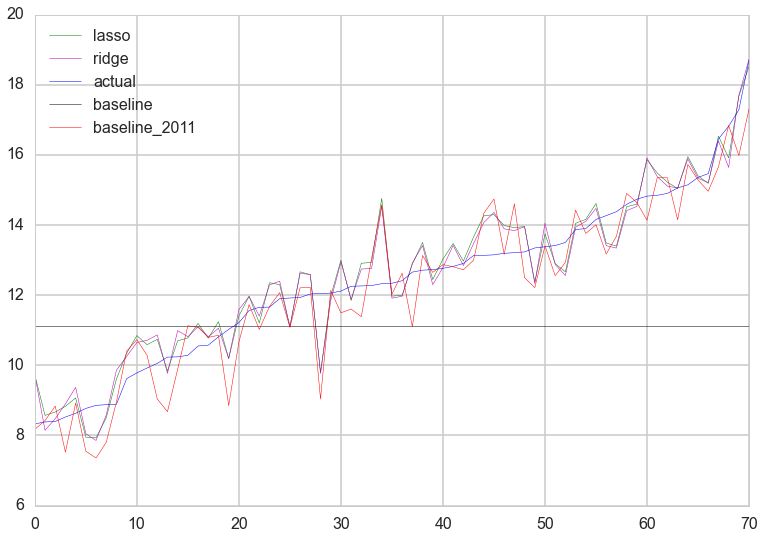

In [47]:
# plot to show difference between baseline, lasso, and ridge regressions
# HOUSE/RENTAL ratio 2015

state='MD'

plt.plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == state].lasso, color='g', linewidth=0.5, label='lasso')
plt.plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == state].ridge, color='m', linewidth=0.5, label='ridge')
plt.plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == state].actual, color='b', linewidth=0.5, label='actual')
plt.plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == state].baseline, color='k', linewidth=0.5, label='baseline')
plt.plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == state].baseline_2011, color='r', linewidth=0.5, label='baseline_2011')
plt.legend(loc='best')
plt.show()

number of good states = 25


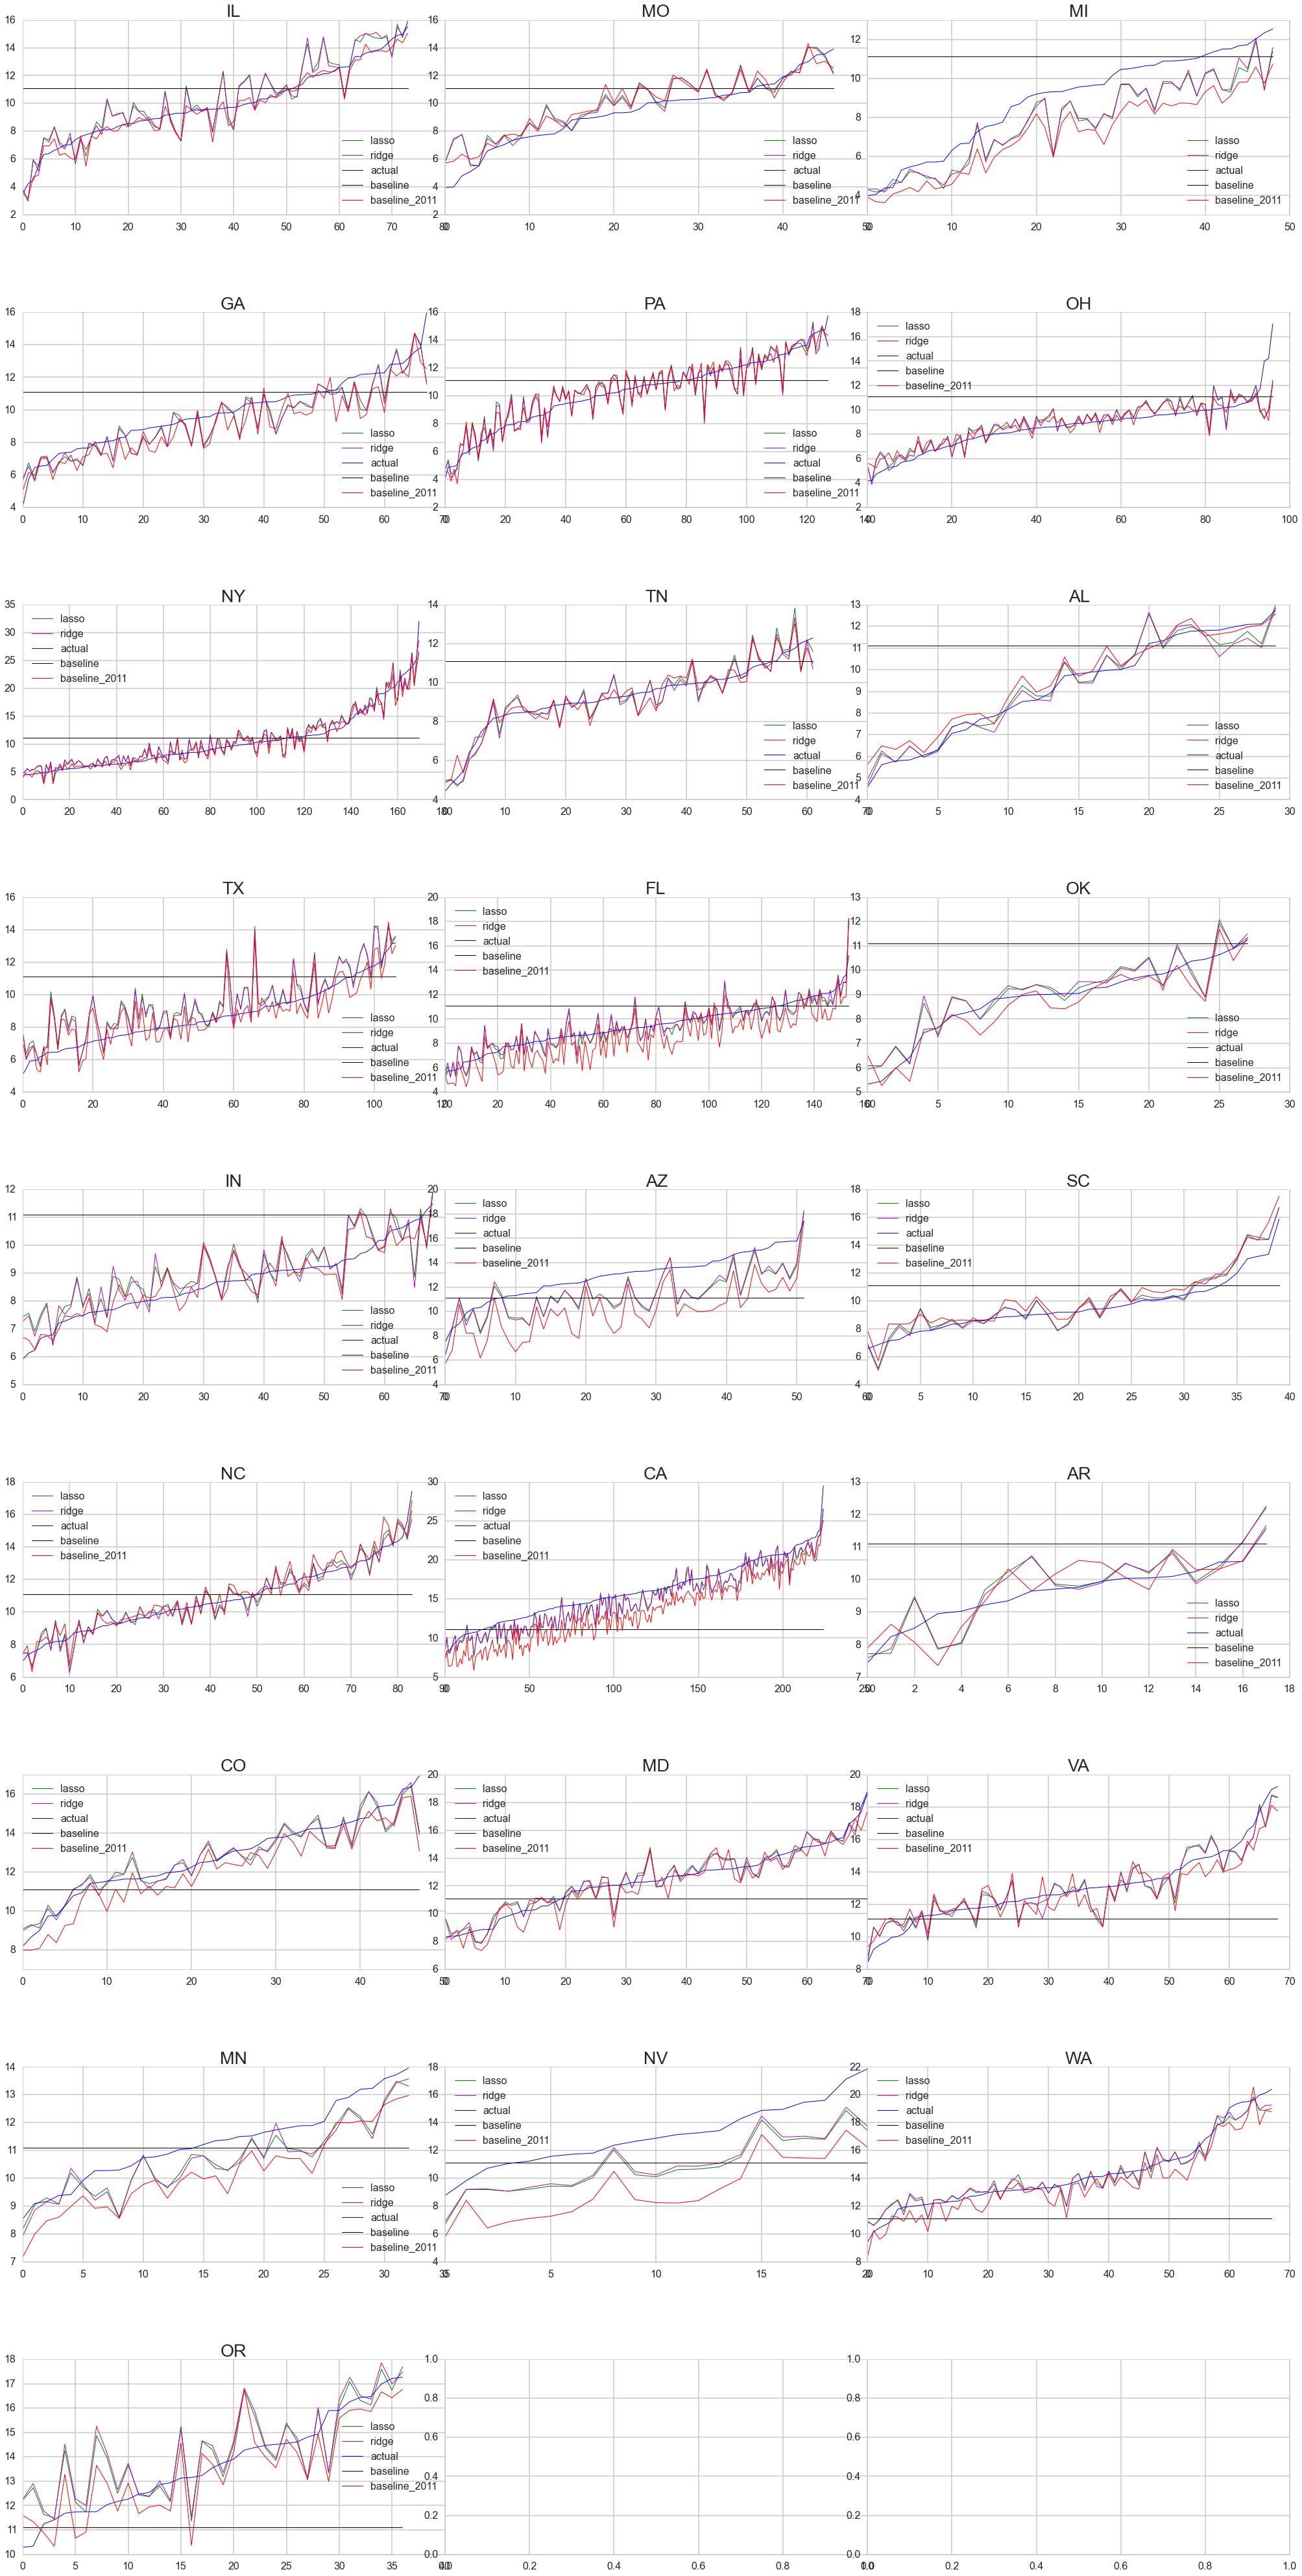

In [48]:
good_states = [s for s in states if (ratio_2015_preds_df[ratio_2015_preds_df['state']==s].shape[0] > 15)]
print 'number of good states = %s'%(len(good_states))

if len(good_states)%3 == 0 :
    nROW = len(good_states)/3
else :
    nROW = np.ceil(len(good_states)/3.).astype(int)
nCOL = 3

# f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))
fig, axs = plt.subplots(nROW, nCOL, figsize=(35, 70), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in xrange(len(good_states)):
    
    axs[i].plot(ratio_2015_preds_df[(ratio_2015_preds_df['state'] == good_states[i])].lasso, color='g', linewidth=1, label='lasso')
    axs[i].plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].ridge, color='m', linewidth=1, label='ridge')
    axs[i].plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].actual, color='b', linewidth=1, label='actual')
    axs[i].plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].baseline, color='k', linewidth=1, label='baseline')
    axs[i].plot(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].baseline_2011, color='r', linewidth=1, label='baseline_2011')
    axs[i].legend(loc='best', fontsize=16)
    axs[i].set_title(str(good_states[i]), fontsize=27)
    
# fig.title('hi')

number of good states = 25


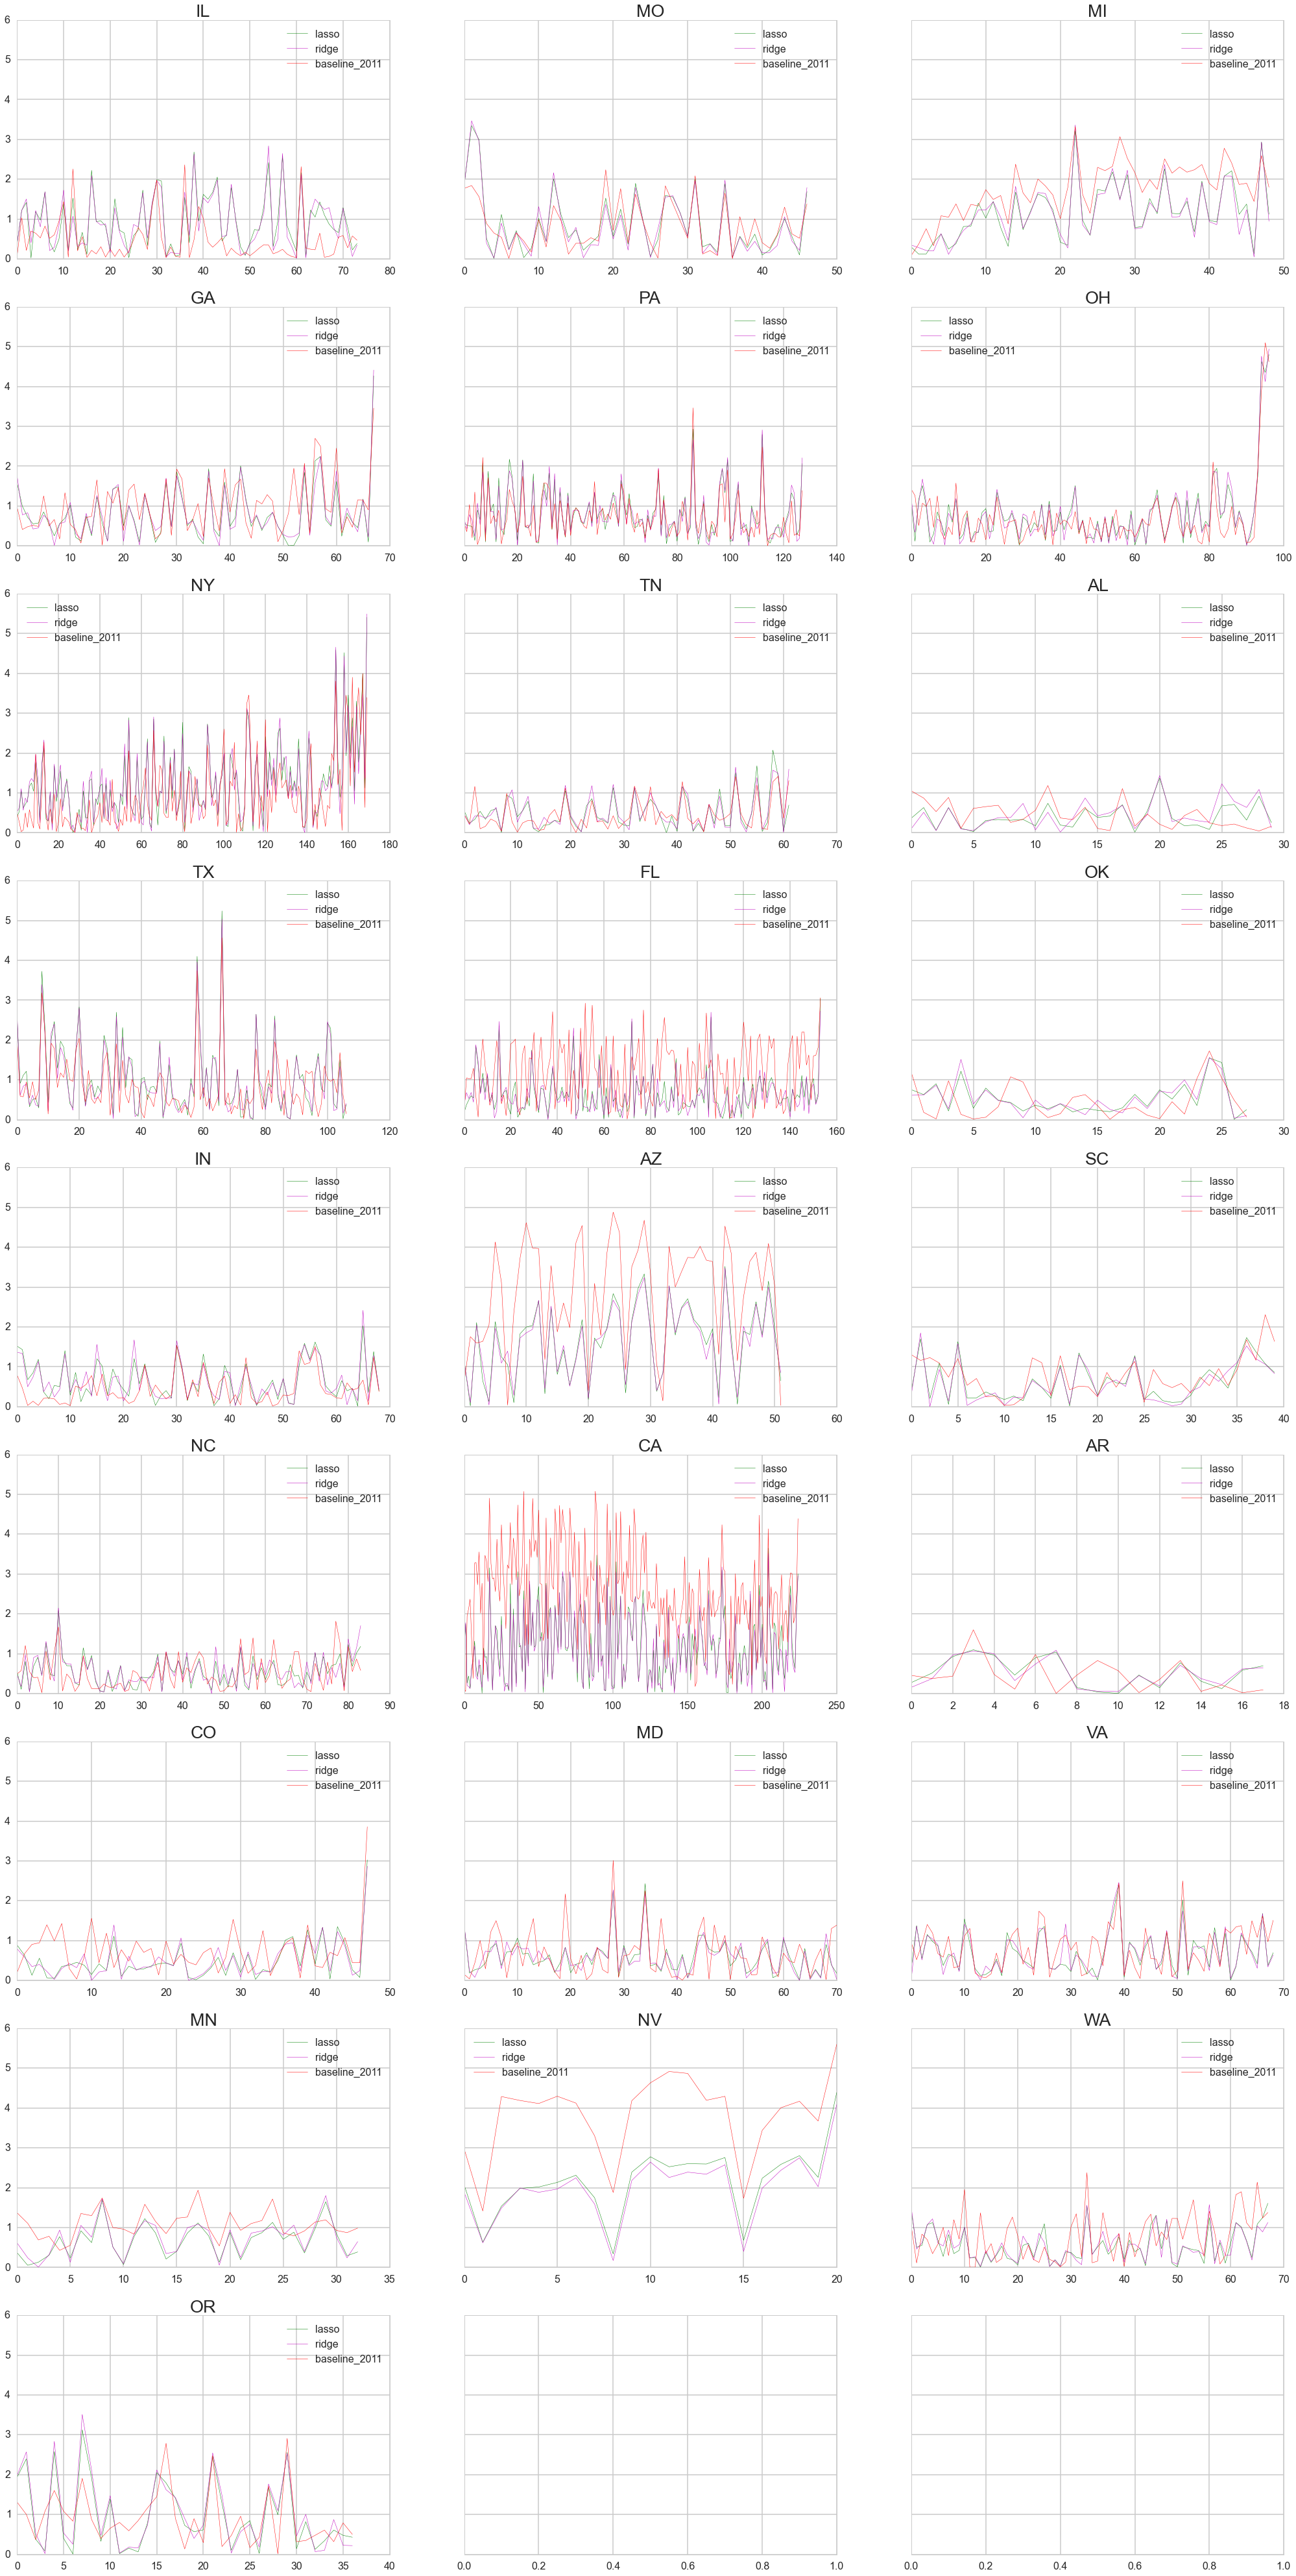

In [49]:
good_states = [s for s in states if (ratio_2015_preds_df[ratio_2015_preds_df['state']==s].shape[0] > 15)]
print 'number of good states = %s'%(len(good_states))

if len(good_states)%3 == 0 :
    nROW = len(good_states)/3
else :
    nROW = np.ceil(len(good_states)/3.).astype(int)
nCOL = 3

# f, ax = plt.subplots(nrows=nROW, ncols=nCOL, figsize=(35,70))
fig, axs = plt.subplots(nROW, nCOL, figsize=(35, 70), sharey=True, facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in xrange(len(good_states)):
    
#     axs[i].plot(abs(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].baseline - ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].actual), color='k', linewidth=0.5, label='baseline')
    axs[i].plot(abs(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].lasso - ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].actual), color='g', linewidth=0.5, label='lasso')
    axs[i].plot(abs(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].ridge - ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].actual), color='m', linewidth=0.5, label='ridge')
    axs[i].plot(abs(ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].baseline_2011 - ratio_2015_preds_df[ratio_2015_preds_df['state'] == good_states[i]].actual), color='r', linewidth=0.5, label='baseline_2011')
#     axs[i].plot(abs(ratio_2015_preds_df.baseline_2011[m:n] - ratio_2015_preds_df.actual[m:n]), color='r', linewidth=0.5, label='baseline_2011')
    axs[i].legend(loc='best', fontsize=16)
    axs[i].set_title(str(good_states[i]), fontsize=27)

In [50]:
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV

svr_model_gs=SVR(kernel='rbf')
Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
epsilons = [.001, .01, .1, 1.0]

start_time = time.time()

n_folds = 5
n_jobs = 4
gs = GridSearchCV(svr_model_gs, param_grid={"C": Cs,"epsilon":epsilons}, cv=n_folds, n_jobs=n_jobs)
gs.fit(X_train, Y_train)

C_best = gs.best_params_['C']
ep_best = gs.best_params_['epsilon']
print 'The best c-value is %s, the best epsilon value is %s'%(C_best, ep_best)

print '----- %s seconds to run -----'%(time.time() - start_time)

The best c-value is 10.0, the best epsilon value is 0.1
----- 455.810647964 seconds to run -----


In [51]:
from sklearn.svm import SVR
start_time = time.time()

svr_model = SVR(C=10.0, epsilon=1.0).fit(X_train, Y_train) 

training_accuracy = svr_model.score(X_train, Y_train)
test_accuracy = svr_model.score(X_test, Y_test)
print '#### based on the best Linear Regression with Ridge Regularization ####'
print "R-squared on training data: %0.2f" % (training_accuracy)
print "R-squared on test data:     %0.2f" % (test_accuracy)

svr_pred = svr_model.predict(X_test)
ridge_rmse = get_rmse(svr_pred, Y_test)

print 'Response Variable: Housing/Rental Ratio 2015'
print 'RMSE for Ridge: ' + str(ridge_rmse)

#### based on the best Linear Regression with Ridge Regularization ####
R-squared on training data: 0.96
R-squared on test data:     0.92
Response Variable: Housing/Rental Ratio 2015
RMSE for Ridge: 1.03912541909


In [ ]:
##### In case we want to do SVM regression/other types of models later

In [ ]:
#calculate the accuracy here
#your code here
start_time = time.time()

best = LinearSVC(C=C_best, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
      penalty='l2', random_state=None, tol=0.0001, verbose=0)
best.fit(Xmatrix_train, Yresp_train)

training_accuracy = best.score(Xmatrix_train, Yresp_train)
test_accuracy = best.score(Xmatrix_test, Yresp_test)
print '#### based on the best LinearSVC ####'
print "Accuracy on training data: %0.2f" % (training_accuracy)
print "Accuracy on test data:     %0.2f" % (test_accuracy)
print '----- %s seconds to run -----'%(time.time() - start_time)